# Model analysis
This notebook will help you to analyze the output from the autoencoder model in the tutorial "Denoising images".

The test dataset (unlabeled) is available here:
https://storage.googleapis.com/bucket-8732/ImageDenoiser/MNISTtest.zip

**Note**: This notebook requires installation of Sidekick. To install the package within the notebook, run the following code:

import sys
!{sys.executable} -m pip install git+https://github.com/Peltarion/sidekick#egg=sidekick

For more information about Sidekick, see: https://github.com/Peltarion/sidekick

In [12]:
import glob
import os
import random

import numpy as np
from PIL import Image
import seaborn as sns
import sidekick
from tqdm import tqdm

## Setup

### Paths

In [13]:
data_dir = './MNISTtest'

### Client to deployment

In [14]:
deployment_url = 'https://...'
deployment_token = '...'

client = sidekick.Deployment(
    url=deployment_url,
    token=deployment_token
)

## Load test data

In [15]:
test_images = []
for filename in glob.glob(os.path.join(data_dir, '*.png')):    
    im=Image.open(filename)
    im2 = im.copy()
    test_images.append(im2)
    im.close()
print('Number of images: {}'.format(len(test_images)))

Number of images: 10000


## Reconstruct test images with added noise

In [16]:
def add_noise(im):
    np_im = np.array(im) # Convert to NP before applying noise
    row, col = np_im.shape 
    gauss = np.random.randn(row, col) # Generate noise
    noisy = np_im + np_im * gauss # Add noise to foreground (black color is not affected) 
    noisy_im = Image.fromarray(noisy) # Convert back to PIL image
    noisy_im = noisy_im.convert("L") # Set image mode to grayscale
    noisy_im.format = 'PNG'
    return noisy_im

def get_reconstruction_error(im, recon_im):
    im_np, recon_im_np = np.array(im) / 255., np.array(recon_im) / 255.
    error = -(im_np * np.log(recon_im_np + 1e-7)).mean()  # Approx. binary crossentropy
    return error

In [17]:
test_images_i = iter(test_images)

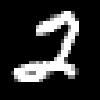

'Original'

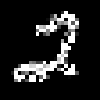

'Noisy'

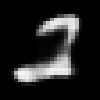

'Denoised'

Reconstruction error (BCE): 0.1311635819992885


In [19]:
im = next(test_images_i)
display(im.resize((100,100)), 'Original')
noisy_im = add_noise(im)
noisy_im.format = 'PNG'
display(noisy_im.resize((100,100)), 'Noisy')
recon_im = client.predict(image=noisy_im)['image']
error = get_reconstruction_error(im, recon_im)
display(recon_im.resize((100, 100)),'Denoised')
print('Reconstruction error (BCE): {}'.format(error))

## Calculate and plot distribution of reconstruction errors

100%|██████████| 1000/1000 [00:45<00:00, 21.83it/s]


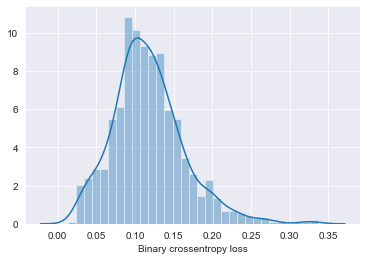

In [20]:
random_samples = random.sample(test_images, k=1000) # 1,000 samples
pbar = tqdm(total=len(random_samples))
errors = []
for im in random_samples:
    noisy_im = add_noise(im)    
    recon_im = client.predict(image=noisy_im)['image']
    im_np, recon_im_np = np.array(im), np.array(recon_im)    
    errors.append(get_reconstruction_error(im_np, recon_im_np))
    pbar.update(1)
pbar.close()
sns.set_style('darkgrid')
sns.distplot(np.array(errors), axlabel='Binary crossentropy loss');